In [2]:
import numpy as np
import matplotlib.pyplot as plt
from util import inicializar_fekete, mostrar_fekete, generar_A, generar_y
import cvxpy as cp
import time

# Ejercicio 1

## parte b)

In [3]:
def calcular_energia(puntos):
    """Calcula la energia total de un conjunto de puntos."""
    n = puntos.shape[1]
    energia = 0
    for i in range(n):
        for j in range(n):
            if i != j:
                diferencia = puntos[:, i] - puntos[:, j]
                distancia = np.linalg.norm(diferencia, 2)
                energia += -np.log(distancia)
    return energia

def gradiente_i_E(puntos, i):
    """Calcula el gradiente de E en el punto x_i."""
    gradiente = np.zeros(3)
    for j in range(puntos.shape[1]):
        if i != j:
            diferencia = puntos[:, i] - puntos[:, j]
            distancia = np.linalg.norm(diferencia)
            gradiente += - 2 * diferencia / (distancia**2)
    return gradiente

def PGD(puntos_iniciales, alfa, epsilon, max_iter=1000):
    """Realiza PGD a partir de los puntos iniciales."""
    puntos = puntos_iniciales.copy()
    n = puntos.shape[1]
    energias = [calcular_energia(puntos)]
    for k in range(max_iter):
        i = k % n
        gradiente = gradiente_i_E(puntos, i)
        nuevo_punto = puntos[:, i] - alfa * gradiente # Paso de gradiente
        nuevo_punto /= np.linalg.norm(nuevo_punto, 2)  # Se proyecta a la esfera

        # Convergencia
        if np.linalg.norm(nuevo_punto - puntos[:, i]) < epsilon:
            puntos[:, i] = nuevo_punto
            energias.append(calcular_energia(puntos))
            break
        puntos[:, i] = nuevo_punto
        energias.append(calcular_energia(puntos))

    return puntos, energias

# Parámetros de prueba
n = 3
alfa = 0.01
epsilon = 1e-3

# Inicialización de puntos
puntos_iniciales = np.array([[0., 1., 0.],
                    [-1, 0., 0.],
                    [0., 0., 1.]])

In [4]:
# Prueba de gradiente numérico
def gradiente_numerico(f, x, h=1e-5):
    grad = np.zeros_like(x[:,0])
    for i in range(len(grad)):
        x[i,0] += h
        f_mas = f(x)
        x[i,0] -= 2*h
        f_menos = f(x)
        grad[i] = (f_mas - f_menos) / (2 * h)
        x[i,0] += h
    return grad


print(f'Gradiente analítico: {gradiente_i_E(puntos_iniciales, 0)}')
print(f'Gradiente numérico: {gradiente_numerico(calcular_energia, puntos_iniciales)}')



Gradiente analítico: [1. 2. 1.]
Gradiente numérico: [1. 2. 1.]


In [5]:
# Prueba de algoritmo
puntos_finales, energias = PGD(puntos_iniciales, alfa, epsilon)
print(puntos_iniciales)
print(puntos_finales)

[[ 0.  1.  0.]
 [-1.  0.  0.]
 [ 0.  0.  1.]]
[[-0.38125908  0.84451995 -0.37609914]
 [-0.8421941   0.37866813  0.37609613]
 [-0.38124876 -0.37867731  0.84681824]]


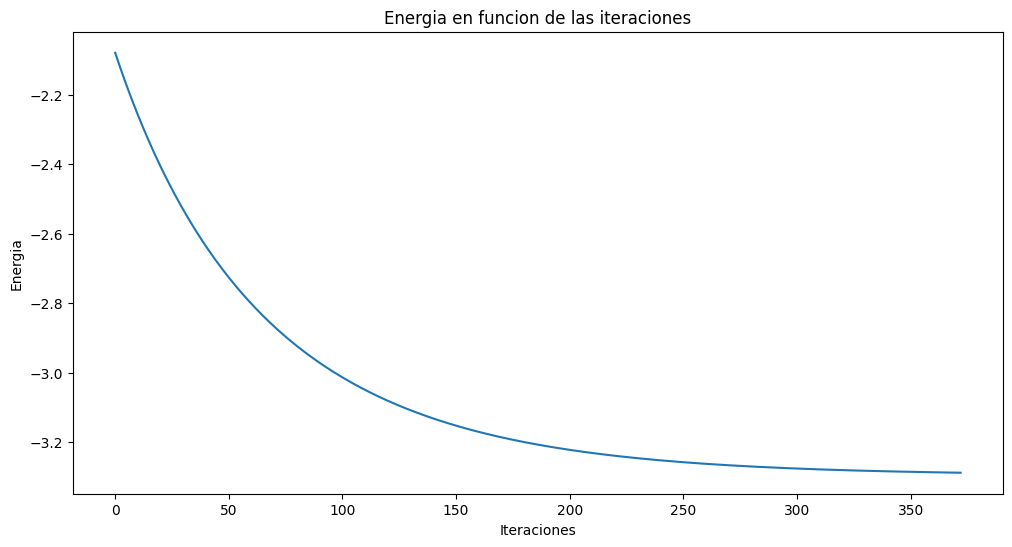

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(energias)
plt.ylabel('Energia')
plt.xlabel('Iteraciones')
plt.title('Energia en funcion de las iteraciones')
plt.show()

## Parte c)

In [11]:
# Parámetros
n = 100
alfa = 0.01
epsilon = 1e-3

# Inicialización de puntos
puntos_iniciales = inicializar_fekete(n)

t_ini = time.time()
puntos_finales, energias = PGD(puntos_iniciales, alfa, epsilon)
t_tot = time.time() - t_ini

print(f'Energía inicial: {calcular_energia(puntos_iniciales)}')
print(f'Energía final: {calcular_energia(puntos_finales)}')
print(f'Tiempo de ejecución: {t_tot}')


Energía inicial: -1937.201790795976
Energía final: -2160.721743173542
Tiempo de ejecución: 35.97718095779419


## Parte d)

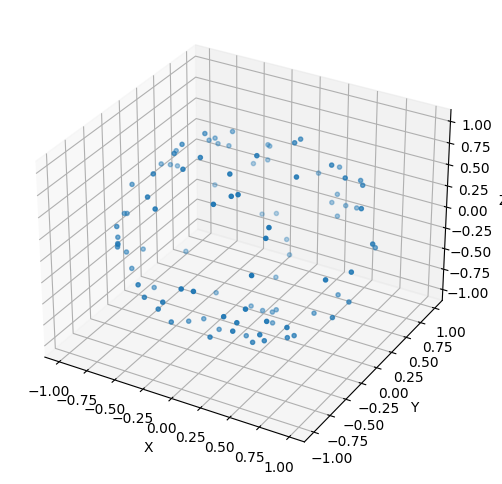

In [8]:
# Mostar puntos iniciales
mostrar_fekete(puntos_iniciales)

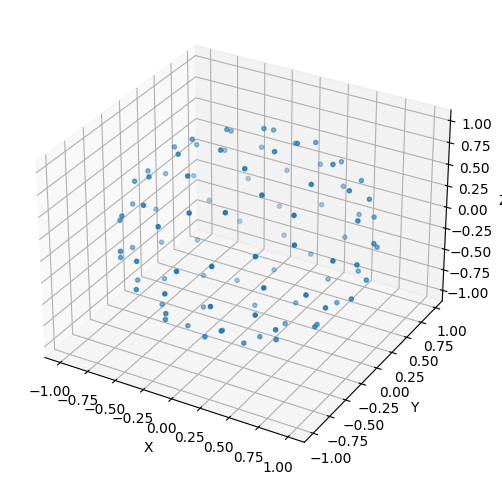

In [12]:
# Mostrar puntos finales
mostrar_fekete(puntos_finales)

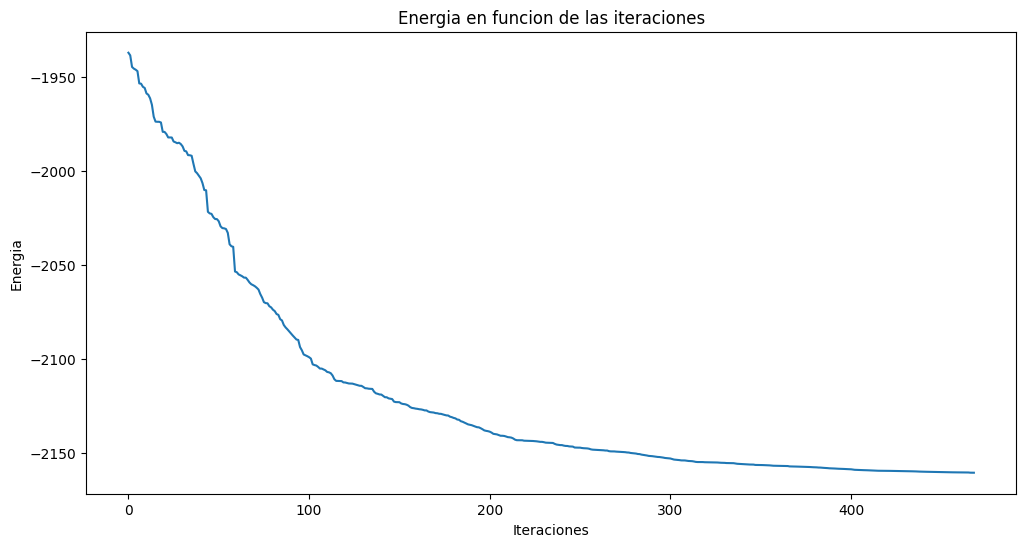

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(energias)
plt.ylabel('Energia')
plt.xlabel('Iteraciones')
plt.title('Energia en funcion de las iteraciones')
plt.show()

# Ejercicio 2

In [ ]:
# Datos
A = generar_A()
y = generar_y()

# Parámetros
theta = 0.1
epsilon = 1e-5 # Condición de parada

## Parte b)

In [ ]:
m, p = A.shape

x = cp.Variable(p)
t = cp.Variable(p)

objetivo = cp.Minimize(0.5 * cp.norm(A @ x - y, 2)**2 + theta * cp.sum(t))

restricciones = [t >= x, t >= -x]

problema = cp.Problem(objetivo, restricciones)

t_ini = time.time()
problema.solve()
t_b = time.time() - t_ini

x_opt_b = x.value
print(f'Primeros 10 elementos: {x_opt_b[:10]}')
print(f'Tiempo de ejecución: {t_b}')

Primeros 10 elementos: [ 2.97682688e-01  4.42441129e-01  1.29592447e-05 -2.58671811e-01
  3.10903242e-01  1.09124969e+00  2.66780651e-01 -2.28603573e+00
  1.78214204e-01  4.74904305e-01]
Tiempo de ejecución: 0.5832428932189941


## Parte c)

In [ ]:
def actualizar_x_i(A, y, x, i, theta):
    p = len(x)
    # Calcular término que no depende de x_i
    c_i = y - (A @ x - A[:, i] * x[i])

    # Actualizar x_i según los calculos realizados
    zeta_prima = A[:, i].T @ c_i / (A[:, i].T @ A[:, i])  # Mínimo de parte dif.
    zeta = np.sign(zeta_prima) * max(abs(zeta_prima) - theta, 0)

    return zeta

def descenso_por_coordenadas(A, y, theta, tolerancia=1e-5, max_iter=2000):
    p = A.shape[1]
    x = np.zeros(p)  # Inicializar x
    for k in range(max_iter):
        x_prev = x.copy()
        for i in range(p):
            x[i] = actualizar_x_i(A, y, x, i, theta)
        # Verificar condición de parada luego de actualizar todo el vector
        if np.linalg.norm(x - x_prev) / np.linalg.norm(x) < tolerancia:
           break
    iteraciones = (k+1)*p
    return x, iteraciones

t_ini = time.time()
x_opt_c, iteraciones_c = descenso_por_coordenadas(A, y, theta)
t_c = time.time() - t_ini

print(f'Primeros 10 elementos: {x_opt_c[:10]}')
print(f'Tiempo de ejecución: {t_c}')
print(f'Iteraciones: {iteraciones_c}')

Primeros 10 elementos: [ 0.29765056  0.44246285  0.         -0.25861608  0.3108792   1.09127633
  0.26671502 -2.28600907  0.17809847  0.47492698]
Tiempo de ejecución: 0.047321319580078125
Iteraciones: 800


## Parte d)

In [ ]:
# Funciones para ADMM
def proximal_g(v, theta, lambd):
  return np.sign(v) * np.maximum(0, np.abs(v) - lambd * theta)

def proximal_f(v, A, y, lambd):
  return np.linalg.inv(np.identity(A.shape[1]) + lambd * A.T @ A) @ (lambd * A.T @ y + v)

def ADMM(A, y, theta, lambd, epsilon, max_iter=2000):
  m, p = A.shape

  # Inicializacion
  x = np.zeros(p)
  z = np.zeros(p)
  u = np.zeros(p)
  valores_objetivo = [funcion_LASSO(x, A, y, theta)]

  for i in range(max_iter):
    x = proximal_f(z - u, A, y, lambd)
    z = proximal_g(x + u, theta, lambd)
    u = u + x - z

    valores_objetivo.append(funcion_LASSO(x, A, y, theta))

    # Condicion de parada
    if abs(valores_objetivo[-1] - valores_objetivo[-2]) < epsilon:
      break

  return x, valores_objetivo

In [ ]:
valores_lambd = [10**i for i in range(-3, 4)]  # de 10^-3 a 10^3
resultados_d = {}
for lambd in valores_lambd:
    t_ini = time.time()
    x, valores_objetivo = ADMM(A, y, theta, lambd, epsilon)
    t_d = time.time() - t_ini
    resultados_d[lambd] = [x, valores_objetivo, t_d]

# Imprimir resultados
for lambd, x in resultados_d.items():
    print(f"Lambda: {lambd}, Iteraciones: {len(x[1])-1}, Tiempo: {x[2]} s, Solución: {x[0][:10]}, función objetivo: {x[1][-1]}")

Lambda: 0.001, Iteraciones: 2000, Tiempo: 4.888044118881226 s, Solución: [ 2.82968897e-01  2.55337007e-01  3.59220920e-08 -1.37536920e-01
  1.24223890e-01  9.71226231e-01  9.12062840e-02 -1.65500706e+00
  2.54469931e-01  3.32649445e-01], función objetivo: 432.1942853132777
Lambda: 0.01, Iteraciones: 820, Tiempo: 3.2495710849761963 s, Solución: [ 2.96287025e-01  4.34751918e-01  1.23510666e-07 -2.57614783e-01
  3.08414279e-01  1.09323348e+00  2.60258210e-01 -2.26919871e+00
  1.85360779e-01  4.68464884e-01], función objetivo: 430.08947458928264
Lambda: 0.1, Iteraciones: 105, Tiempo: 0.17964720726013184 s, Solución: [ 2.97129274e-01  4.39870291e-01  3.69391991e-06 -2.58527850e-01
  3.10550917e-01  1.09196297e+00  2.64578031e-01 -2.28084601e+00
  1.80624747e-01  4.72659572e-01], función objetivo: 430.08871019795487
Lambda: 1, Iteraciones: 19, Tiempo: 0.031450510025024414 s, Solución: [ 2.97597172e-01  4.42260553e-01  4.39987614e-05 -2.58624776e-01
  3.10894793e-01  1.09130836e+00  2.6654609

## Parte e)

In [ ]:
print('***Resolviendo problema P1 con CVXPY***')
print(f'x*: {x_opt_b}')
print(f'Valor función de costo: {funcion_LASSO(x_opt_b, A, y, theta)}')
print(f'Tiempo de ejecución: {t_b}')
print(f'Cantidad de ceros en la solución: {np.sum(np.abs(x_opt_b) <= 1e-3)}')
print(f'Norma L1 de la solución: {np.linalg.norm(x_opt_b, 1)}')
print('')
print('***Resolviendo problema P0 con descenso por coordenadas***')
print(f'x*: {x_opt_c}')
print(f'Valor función de costo: {funcion_LASSO(x_opt_c, A, y, theta)}')
print(f'Tiempo de ejecución: {t_c}')
print(f'Cantidad de ceros en la solución: {np.sum(np.abs(x_opt_c) <= 1e-3)}')
print(f'Norma L1 de la solución: {np.linalg.norm(x_opt_c, 1)}')
print('')
print('***Resolviendo problema P0 con ADMM (lambda=1)***')
print(f'x*: {resultados_d[1][0]}')
print(f'Valor función de costo: {resultados_d[1][1][-1]}')
print(f'Tiempo de ejecución: {resultados_d[1][2]}')
print(f'Cantidad de ceros en la solución: {np.sum(np.abs(resultados_d[1][0]) <= 1e-3)}')
print(f'Norma L1 de la solución: {np.linalg.norm(resultados_d[1][0], 1)}')

***Resolviendo problema P1 con CVXPY***
x*: [ 2.97682688e-01  4.42441129e-01  1.29592447e-05 -2.58671811e-01
  3.10903242e-01  1.09124969e+00  2.66780651e-01 -2.28603573e+00
  1.78214204e-01  4.74904305e-01  1.66117363e+00 -4.52335999e-05
 -6.21847550e-01  1.84980941e-01  8.80596676e-01  1.73377616e+00
  8.42542481e-06  2.05158302e+00  1.37060214e+00  2.60017051e-01
  1.74253198e-01  1.54343721e+00  2.96819347e-01  1.52438193e+00
  3.52186067e-01 -5.82300873e-01  1.52461160e+00  9.20013101e-06
  8.51829343e-01 -1.55569314e+00 -3.36836999e-01  2.23643203e+00
  1.06314089e+00  2.97397699e-01  3.33534791e-01 -1.20180793e+00
  2.12259591e-01 -1.64486869e-01 -2.05407421e+00 -3.52127759e-01
 -1.63679836e+00 -1.32803518e+00  1.61389168e+00 -2.01061282e+00
 -1.10677660e-01  2.04084044e-02 -6.88499734e-01  3.19790686e-01
 -1.47836807e+00  2.07843694e+00 -4.16034430e-01 -1.68709244e+00
 -2.27946759e-01 -1.81758692e-01  2.04217244e+00  6.46245822e-01
 -2.05704189e-07  4.25078156e-02 -5.21682864e-